


### ローカルファイルのアップロード処理




In [3]:
from google.colab import files
uploaded_test = files.upload()

Saving test.csv to test.csv


In [0]:
import pandas as pd
import io
test_data = pd.read_csv(io.StringIO(uploaded_test['test.csv'].decode('utf-8')))


In [5]:
uploaded_train = files.upload()

Saving train.csv to train.csv


In [0]:
train_data = pd.read_csv(io.StringIO(uploaded_train['train.csv'].decode('utf-8')))

In [7]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 欠損データの確認（各カラムのNull値サマリ）

In [9]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### カテゴリデータをダミーデータ化する関数

In [0]:
def change_to_dummy(df, col_name):
    
    dum_data = pd.get_dummies(df[col_name])
    return pd.concat((df, dum_data), axis=1) 


In [0]:
train_data_proc = change_to_dummy(train_data, 'Sex')
train_data_proc = change_to_dummy(train_data_proc, 'Embarked')

test_data_proc = change_to_dummy(test_data, 'Sex')
test_data_proc = change_to_dummy(test_data_proc, 'Embarked')

### 名前をフラグに変換し、後でクラスタリングする

In [0]:

def name_classifier(name_df):    
    name_class_df = pd.DataFrame(columns={'miss','mrs','master','mr'})
    
    for name in name_df:        
        if 'Miss' in name:
            df = pd.DataFrame([[1,0,0,0]],columns={'miss','mrs','master','mr'})
        elif 'Mrs' in name:
            df = pd.DataFrame([[0,1,0,0]],columns={'miss','mrs','master','mr'})
        elif 'Master' in name:
            df = pd.DataFrame([[0,0,1,0]],columns={'miss','mrs','master','mr'})
        elif 'Mr' in name:
            df = pd.DataFrame([[0,0,0,1]],columns={'miss','mrs','master','mr'})
        else :
            df = pd.DataFrame([[0,0,0,0]],columns={'miss','mrs','master','mr'})
        name_class_df = name_class_df.append(df,ignore_index=True)        
    return name_class_df

In [0]:
name_class_df = name_classifier(train_data_proc['Name'])

In [15]:
train_data_proc = pd.concat( (train_data_proc, name_class_df), axis=1)
train_data_proc.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,female,male,C,Q,S,mrs,mr,miss,master
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,0,1,0,0,1,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,1,0,1,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,1,0,0,0,1,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,1,0,0,0,1,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,0,1,0,0,1,0,0,0,1


In [0]:
def estimate_age_by_distance(train_df):
    perfect_df = train_df.dropna()
    perfect_df_master = perfect_df[perfect_df.master==1]
    perfect_df_mr = perfect_df[perfect_df.mr==1]
    perfect_df_mrs = perfect_df[perfect_df.mrs==1]
    perfect_df_miss = perfect_df[perfect_df.miss==1]
    perfect_df_other = perfect_df.query("master==0 and mr==0 and mrs==0 and miss==0")

    est_age_df = pd.DataFrame(columns={'est_age'})
    
    for row in range(0,len(train_df)):
        df = train_df.iloc[row]
        distance_list = []

        if df.Age > 0:
            est_age = pd.DataFrame([[df.Age]],columns={'est_age'})
        else:
            if df.master == 1:
                for p_row in range(0,len(perfect_df_master)):
                    df2 = perfect_df_master.iloc[p_row]                    
                    distance = distance_between_df_row(train_df,perfect_df_master,df,df2)
                    distance_list.append([df2.Age,distance])                                                        
            elif df.mr == 1:
                for p_row in range(0,len(perfect_df_mr)):
                    df2 = perfect_df_mr.iloc[p_row]                    
                    distance = distance_between_df_row(train_df,perfect_df_mr,df,df2)
                    distance_list.append([df2.Age,distance])                                    

            elif df.mrs == 1:
                for p_row in range(0,len(perfect_df_mrs)):
                    df2 = perfect_df_mrs.iloc[p_row]                    
                    distance = distance_between_df_row(train_df,perfect_df_mrs,df,df2)
                    distance_list.append([df2.Age,distance])                                    
            elif df.miss == 1:
                for p_row in range(0,len(perfect_df_miss)):
                    df2 = perfect_df_miss.iloc[p_row]                    
                    distance = distance_between_df_row(train_df,perfect_df_miss,df,df2)
                    distance_list.append([df2.Age,distance])                                    
            else:
                for p_row in range(0,len(perfect_df_other)):
                    df2 = perfect_df_other.iloc[p_row]                    
                    distance = distance_between_df_row(train_df,perfect_df_other,df,df2)
                    distance_list.append([df2.Age,distance])                                                    
                    
            distance_list.sort(key=lambda x: x[1])          
            sum_age = 0
            avg_age = 0

            for k in range(0,3):
                sum_age = sum_age + distance_list[k][0]
            avg_age = sum_age / 3    
            est_age = pd.DataFrame([[avg_age]],columns={'est_age'})                
        est_age_df = est_age_df.append(est_age,ignore_index=True)        

    return est_age_df

In [22]:
estimate_age_by_distance(train_data_proc).head()

NameError: ignored

### DataFrameのカラムを削除する関数

In [0]:
def drop_column(data_frame, col_name):
    
    # 削除対象がリストで渡された場合
    if isinstance(col_name, list) and len(col_name) > 0:
        return drop_column(data_frame.drop(col_name.pop(0) , axis=1), col_name)
          
    return data_frame.drop(col_name, axis=1)

In [0]:
train_data_proc = drop_column(train_data_proc, ['Sex', 'male', 'S', 'Cabin','Ticket'])

test_data_proc = drop_column(test_data_proc, ['Sex', 'male', 'S', 'Cabin','Ticket'])

### 各カラムの相関係数の一覧（Survivedとの関連が高いものを把握したい）

In [30]:
train_data_proc.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,female,C,Q
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,-0.042939,-0.001205,-0.033606
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.543351,0.168240,0.003650
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.131900,-0.243292,0.221009
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.093254,0.036261,-0.022405
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.114631,-0.059528,-0.026354
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.245489,-0.011069,-0.081228
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.182333,0.269335,-0.117216
female,-0.042939,0.543351,-0.131900,-0.093254,0.114631,0.245489,0.182333,1.000000,0.082853,0.074115
C,-0.001205,0.168240,-0.243292,0.036261,-0.059528,-0.011069,0.269335,0.082853,1.000000,-0.148258
Q,-0.033606,0.003650,0.221009,-0.022405,-0.026354,-0.081228,-0.117216,0.074115,-0.148258,1.000000


In [23]:
train_data_proc.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,female,male,C,Q,S,mrs,mr,miss,master
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,0,1,0,0,1,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,1,0,1,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,1,0,0,0,1,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,1,0,0,0,1,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,0,1,0,0,1,0,0,0,1


In [0]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

ヒートマップにしてみるとこんな感じ

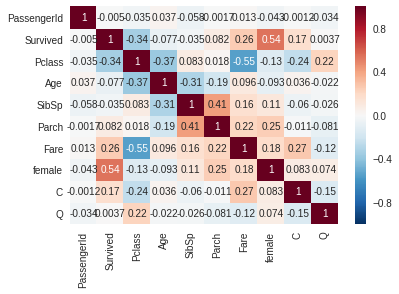

In [16]:
plt.figure()
sns.heatmap(train_data_proc.corr(), annot=True)

### replaceメソッドを使ったダミー変数化

In [0]:
train_data_proc['Embarked'] = train_data_proc['Embarked'].replace(['C','S','Q'], [0,1,2])
test_data_proc['Embarked'] = test_data_proc['Embarked'].replace(['C','S','Q'], [0,1,2])

### 欠損データの補完（推定）

In [0]:
train_data_proc['Embarked'] = train_data_proc['Embarked'].fillna(train_data_proc['Embarked'].median())
train_data_proc['Age'] = train_data_proc['Age'].fillna(train_data_proc['Age'].median())

test_data_proc['Embarked'] = test_data_proc['Embarked'].fillna(test_data_proc['Embarked'].median())
test_data_proc['Age'] = test_data_proc['Age'].fillna(test_data_proc['Age'].median())
test_data_proc['Fare'] = test_data_proc['Fare'].fillna(test_data_proc['Fare'].median())

In [19]:
train_data_proc.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
female         0
C              0
Q              0
dtype: int64

In [20]:
test_data_proc.isnull().sum()

PassengerId    0
Pclass         0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
female         0
C              0
Q              0
dtype: int64

### 説明変数と目的変数に分割

In [0]:
y_train = train_data_proc['Survived'].values
X_train  = train_data_proc[["Pclass", "Age", "SibSp", "Parch","Fare","Embarked", "female"]].values

X_test  = test_data_proc[["Pclass", "Age", "SibSp", "Parch","Fare","Embarked", "female"]].values

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [0]:
# パイプラインを定義
pipe_svc = Pipeline([('scl', StandardScaler()),
            ('clf', SVC(random_state=1))])

# パラメータの種類を定義
param_range = [0.001, 0.01, 0.1, 1.0, 10.0,]

# グリッドサーチするパラメータの組み合わせ
param_grid = [{'clf__C': param_range,  # パラメータの範囲
               'clf__kernel': ['linear']}, # SVCのパラメータ
                 {'clf__C': param_range, 
                  'clf__gamma': param_range, 
                  'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, # アルゴリズム（パイプライン）
                  param_grid=param_grid, # グリッドサーチするパラメータ
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)

In [0]:
gs = gs.fit(X_train, y_train)

In [25]:
print(gs.best_score_)
print(gs.best_params_)

0.8249158249158249
{'clf__C': 1.0, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}


###  予測を実施

In [0]:
predictions = gs.predict(X_test)

### テスト値を再読み込みして，SVMでクラス分類したカラムを追加

In [0]:
test_data["Survived"] = predictions

### 内容を確認

In [28]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [0]:
ans_data = test_data[["PassengerId","Survived"]]

In [0]:
from google.colab import files
ans_data.to_csv('submission.csv', index=False)
files.download('submission.csv')